### Install and import relevant libraries

In [ ]:
pip install sentence_transformers

     |████████████████████████████████| 79 kB 2.4 MB/s 
     |████████████████████████████████| 3.5 MB 11.9 MB/s 
     |████████████████████████████████| 1.2 MB 44.5 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
     |████████████████████████████████| 596 kB 17.1 MB/s 
     |████████████████████████████████| 6.8 MB 34.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=af352fb859de6515dccf021034d09a5ad4ab0942c9ff71efe60a7e98c73f1d7e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!python3 -m spacy download en_core_web_lg
# Restart runtime after this

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import pandas as pd
import psycopg2
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
conn = psycopg2.connect(
    host="codd01.research.northwestern.edu",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

## Load csv files

In [ ]:
df = pd.read_sql_query("select * from data_officerallegation", con=conn)
narratives = pd.read_sql_query("select * from data_allegation", con=conn)

## 1. Merge tables

In [ ]:
df.head()

,id,start_date,end_date,officer_age,recc_finding,recc_outcome,final_finding,final_outcome,final_outcome_class,allegation_category_id,officer_id,disciplined,created_at,updated_at,allegation_id
0,510,1983-08-13,1986-12-03,None,,Unknown,SU,Separation,,104.0,13617,True,2019-01-09 04:41:59.265501+00:00,2019-01-09 04:42:02.108401+00:00,C132885
1,1582,1986-03-15,1989-06-14,None,,Unknown,SU,Separation,,98.0,23618,True,2019-01-09 04:41:59.265501+00:00,2019-01-09 04:42:02.108401+00:00,C149900
2,1738,1986-06-24,1988-10-18,None,,Unknown,SU,Separation,,53.0,3049,True,2019-01-09 04:41:59.265501+00:00,2019-01-09 04:42:02.108401+00:00,C151502
3,1797,1986-08-04,1987-03-09,None,,Unknown,SU,Reprimand,,185.0,5124,True,2019-01-09 04:41:59.265501+00:00,2019-01-09 04:42:02.108401+00:00,C152222
4,2393,1987-07-30,1990-04-11,None,,Unknown,SU,Separation,,197.0,5383,True,2019-01-09 04:41:59.265501+00:00,2019-01-09 04:42:02.108401+00:00,C157296


In [ ]:
narratives.head()

,crid,summary,add2,city,incident_date,point,source,beat_id,is_officer_complaint,add1,location,old_complaint_address,first_end_date,first_start_date,most_common_category_id,coaccused_count,subjects,created_at,updated_at,is_extracted_summary,cr_text
0,1026713,,,,2009-04-30 19:00:00-05:00,None,,244.0,False,,Private Residence,None,2009-08-19,2009-05-26,205.0,13,[],2019-01-09 04:41:26.530261+00:00,2019-01-08 22:41:31.205347-06:00,False,None
1,1026714,,E GOLF RD,SCHAUMBURG IL 60173,2009-03-25 19:00:00-05:00,0101000020E6100000C881B284100256C09B32816CA306...,,2.0,False,19XX,Other Business Establishment,None,2009-10-26,2009-05-26,173.0,1,[],2019-01-09 04:41:26.530261+00:00,2019-01-08 22:41:31.205347-06:00,False,None
2,1026717,,,,2009-05-25 19:00:00-05:00,None,,261.0,False,,Private Residence,None,2009-10-10,2009-05-26,71.0,2,[],2019-01-09 04:41:26.530261+00:00,2019-01-08 22:41:31.205347-06:00,False,None
3,1026719,,,,2009-05-23 19:00:00-05:00,None,,261.0,False,,Private Residence,None,2009-12-07,2009-05-27,72.0,2,[],2019-01-09 04:41:26.530261+00:00,2019-01-08 22:41:31.205347-06:00,False,None
4,1026722,,N PINE AVE,CHICAGO IL 60644,2009-05-20 19:00:00-05:00,0101000020E6100000F286EA9CD5F055C006A3EDF373F1...,,79.0,False,3XX,Public Way - Other,None,2009-12-22,2009-05-27,70.0,1,[],2019-01-09 04:41:26.530261+00:00,2019-01-08 22:41:31.205347-06:00,False,None


In [ ]:
# Extract sustained and unsustained outcomes in two different dataframes
unsus_alleg = df[(df['final_finding'] == 'UN') | (df['final_finding'] == 'EX') | (df['final_finding'] == 'NS')]
sus_alleg = df[df['final_finding'] == 'SU']

In [ ]:
# Merge the officer complaints with data_allegation to get complaint report linked to the allegation
unsus_data = pd.merge(unsus_alleg, narratives, left_on='allegation_id', right_on='crid')
sus_data = pd.merge(sus_alleg, narratives, left_on='allegation_id', right_on='crid')

In [ ]:
# We are interested only in two columns so drop the rest
sus_data = sus_data[['allegation_id','cr_text']]
unsus_data = unsus_data[['allegation_id','cr_text']]

In [ ]:
# Drop the rows with empty complaint report field
print(sus_data.shape)
sus_data = sus_data.dropna()
print(sus_data.shape)

(21990, 2)
(315, 2)


In [ ]:
# Drop the rows with empty complaint report field
print(unsus_data.shape)
unsus_data = unsus_data.dropna()
print(unsus_data.shape)

(184582, 2)
(1276, 2)


In [ ]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))
# print(sorted(stop_words))


# extend_list = ['alleged', 'missing', 'accused', 'alleges', 'reporting', 'party', 'officer', 'chicago', 'police', 'finding','none', 'entered','complainant', 'allegation', 'initial', 'intake', 'hour']
# for i in extend_list:
    # stop_words.add(i)

In [ ]:
sus_data['cr_text'] = sus_data['cr_text'].apply(lambda x: str(x).replace('\n',' '))
unsus_data['cr_text'] = unsus_data['cr_text'].apply(lambda x: str(x).replace('\n',' '))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sus_data.iloc[1,1]

"Initial / Intake Allegation 1: It is reported that the accused officers were inattentative to duty in that, the accused officer failed to properly search a prisoner's property bag (Back Pack), which resulted into retrieving three (3) bags of green leafy substance suspect as cannabis which was not inventoried at that time. It is reported that the accused officers were inattentative to duty in that, the accused officer failed to properly search a prisoner's property bag (Back Pack), which resulted into retrieving three (3) bags of green leafy substance, suspect as cannabis which was not inventoried at that time. Initial / Intake Allegation 12: It is reported that the accused officers were inattentative to duty in that, the accused officer failed to properly search a prisoner's property bag (Back Pack), which resulted into retrieving three (3) bags of green leafy substance suspect as cannabis which was. not inventoried at that time. It is reported that the accused officers were inattenta

In [ ]:
# Pre-process dataset to get a cleaned and normalised text corpus
def clean_text(dataset, datacol):
    corpus = []
    dataset['word_count'] = dataset[datacol].apply(lambda x: len(str(x).split(" ")))
    ds_count = len(dataset.word_count)
    for i in range(0, ds_count):
        
        # Remove punctuation
#         text = re.sub('[^a-zA-Z]', ' ', str(dataset[datacol][i]))

        # Remove special characters and digits
        text = re.sub("(\\d|\\W)+"," ",str(dataset[datacol].iloc[i]))

        # Convert to lowercase
        text = text.lower()

        # Remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        
        # Convert to list from string
        text = text.split()

        # Stemming
        ps=PorterStemmer()

        # Lemmatisation
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in  
                stop_words] 
        text = " ".join(text)
        text = text.replace('initial intake allegation ', '')
        text = text.replace('reporting party alleges accused officer ', '')
        corpus.append(text)
    
    return corpus, ds_count

In [ ]:
unsus_corpus, unsus_ds_count = clean_text(unsus_data, 'cr_text')
sus_corpus, sus_ds_count = clean_text(sus_data, 'cr_text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


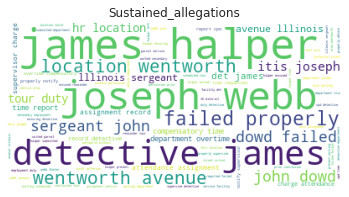

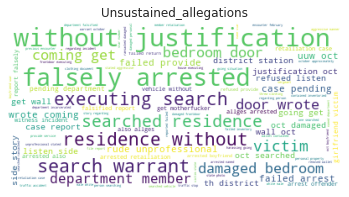

In [ ]:
# Generate word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud_sus = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(sus_corpus))
wordcloud_unsus = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(unsus_corpus))
fig = plt.figure(1)
plt.imshow(wordcloud_sus)
plt.title('Sustained_allegations')
plt.axis('off')
fig = plt.figure(2)
plt.imshow(wordcloud_unsus)
plt.title('Unsustained_allegations')
plt.axis('off')
plt.show()

### Use BERT to extract keywords

In [ ]:
# We use a separate cleaning function customised for BERT
def basic_clean(dataset, datacol):
    corpus = ""
    dataset['word_count'] = dataset[datacol].apply(lambda x: len(str(x).split(" ")))
    ds_count = len(dataset.word_count)
    for i in range(0, ds_count):
        
        text = re.sub("(\\d|\\W)+"," ",str(dataset[datacol].iloc[i]))

        # Convert to lowercase
        text = text.lower()

        # Remove tags
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

        text = text.split()
        text = [x for x in text if not x in stop_words]
        text = " ".join(text)
        corpus = corpus + ". " + text
    
    return "\"" + corpus + "\""

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# sentences = "On October 27, an area of convection with a broad circulation persisted southeast of Guam, and slowly consolidated due to moderate wind shear."


with open('test_sentences.txt') as file:
   sentences = [line.strip() for line in file]

for sentence in sentences:
  cv_sus = CountVectorizer(max_features=10000, ngram_range=(2,2))
  X_sus = cv_sus.fit_transform([sentence])


  # Get feature names
  sus_feature_names=cv_sus.get_feature_names()

  # Sentence representations from SentenceTransformer
  sus_doc_embedding = model.encode([sentence])
  sus_candidate_embeddings = model.encode(sus_feature_names)

  top_n = 10
  distances = cosine_similarity(sus_doc_embedding, sus_candidate_embeddings)
  sus_keywords = [sus_feature_names[index] for index in distances.argsort()[0][-top_n:]]
  print('Test Sentence: ', sentence)
  print('Keywords are: ', sus_keywords)
  print('\n\n')

Test Sentence:  On October 27, an area of convection with a broad circulation persisted southeast of Guam, and slowly consolidated due to moderate wind shear.
Keywords are:  ['27 an', 'slowly consolidated', 'southeast of', 'convection with', 'on october', 'of convection', 'persisted southeast', 'moderate wind', 'october 27', 'wind shear']



Test Sentence:  On release, the four reviewers of Electronic Gaming Monthly applauded Block Ball for the formula to create a new and enjoyable game.
Keywords are:  ['on release', 'create new', 'block ball', 'ball for', 'four reviewers', 'enjoyable game', 'electronic gaming', 'applauded block', 'gaming monthly', 'monthly applauded']



Test Sentence:  Criticism of Du Fu ’s works has focused on his strong sense of history, his moral engagement, and his technical excellence.
Keywords are:  ['has focused', 'technical excellence', 'strong sense', 'history his', 'of history', 'his strong', 'his technical', 'criticism of', 'moral engagement', 'his moral']

In [ ]:
# Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re

cv_sus = CountVectorizer(stop_words=stop_words, max_features=10000, ngram_range=(1,1))
X_sus = cv_sus.fit_transform([sus_uncleaned])

cv_unsus = CountVectorizer(stop_words=stop_words, max_features=10000, ngram_range=(1,1))
X_unsus = cv_unsus.fit_transform([unsus_uncleaned])

# Get feature names
sus_feature_names=cv_sus.get_feature_names()
unsus_feature_names=cv_unsus.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
unsus_doc_embedding = model.encode([unsus_uncleaned])
unsus_candidate_embeddings = model.encode(unsus_feature_names)

sus_doc_embedding = model.encode([sus_uncleaned])
sus_candidate_embeddings = model.encode(sus_feature_names)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

top_n = 10
distances = cosine_similarity(unsus_doc_embedding, unsus_candidate_embeddings)
unsus_keywords = [unsus_feature_names[index] for index in distances.argsort()[0][-top_n:]]

distances = cosine_similarity(sus_doc_embedding, sus_candidate_embeddings)
sus_keywords = [sus_feature_names[index] for index in distances.argsort()[0][-top_n:]]

In [ ]:
print(sus_keywords)

['arrestee', 'nappropriats', 'narcotics', 'mislaid', 'marijuana', 'heroin', 'urinating', 'felony', 'robbery', 'burglary']


In [ ]:
print(unsus_keywords)

['cocaine', 'urinated', 'raped', 'divorce', 'nappropiately', 'burglar', 'urinating', 'burglary', 'burglarized', 'burglarizing']


In [ ]:
list(cv_sus.vocabulary_.keys())[:15]

['reported',
 'officers',
 'inattentative',
 'duty',
 'failed',
 'properly',
 'search',
 'prisoner',
 'property',
 'bag',
 'back',
 'pack',
 'resulted',
 'retrieving',
 'three']

In [ ]:
list(cv_unsus.vocabulary_.keys())[:15]

['grabbed',
 'victim',
 'porch',
 'choked',
 'struck',
 'face',
 'oct',
 'hours',
 'adarms',
 'st',
 'mingari',
 'adams',
 'forearm',
 'fist',
 'sustained']

In [ ]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot
top_words_sus = get_top_n_words(sus_corpus, n=20)
top_df_sus = pd.DataFrame(top_words_sus)
top_df_sus.columns=["Keyword", "Frequency"]
print(top_df_sus)

top_words_unsus = get_top_n_words(unsus_corpus, n=20)
top_df_unsus = pd.DataFrame(top_words_unsus)
top_df_unsus.columns=["Keyword", "Frequency"]
print(top_df_unsus)


       Keyword  Frequency
0         hour        781
1       failed        725
2       halper        688
3        james        677
4       joseph        615
5         webb        590
6         duty        581
7    detective        580
8     reported        561
9   department        559
10    location        536
11    sergeant        484
12   wentworth        478
13        itis        464
14    properly        452
15        time        451
16      avenue        371
17        dowd        370
18        john        370
19      report        340
          Keyword  Frequency
0         officer       2488
1            hour       1391
2          failed       1306
3         without       1183
4        arrested       1135
5          victim       1001
6   justification        988
7          report        906
8        searched        833
9         vehicle        807
10        falsely        807
11            oct        737
12         arrest        721
13        warrant        714
14         stated  

[Text(0, 0, 'officer'),
 Text(0, 0, 'hour'),
 Text(0, 0, 'failed'),
 Text(0, 0, 'without'),
 Text(0, 0, 'arrested'),
 Text(0, 0, 'victim'),
 Text(0, 0, 'justification'),
 Text(0, 0, 'report'),
 Text(0, 0, 'searched'),
 Text(0, 0, 'vehicle'),
 Text(0, 0, 'falsely'),
 Text(0, 0, 'oct'),
 Text(0, 0, 'arrest'),
 Text(0, 0, 'warrant'),
 Text(0, 0, 'stated'),
 Text(0, 0, 'refused'),
 Text(0, 0, 'damaged'),
 Text(0, 0, 'department'),
 Text(0, 0, 'residence'),
 Text(0, 0, 'get')]

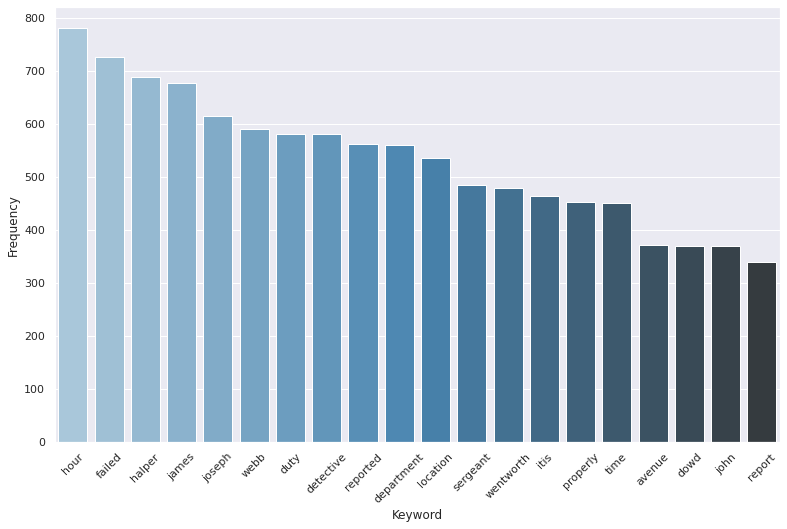

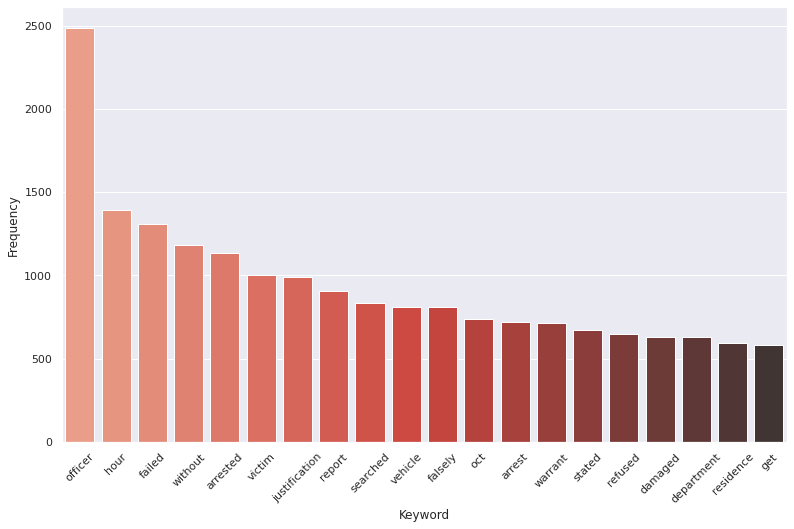

In [ ]:
# Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
fig = plt.figure(1)
g_sus = sns.barplot(x="Keyword", y="Frequency", data=top_df_sus, palette="Blues_d")
g_sus.set_xticklabels(g_sus.get_xticklabels(), rotation=45)
fig = plt.figure(2)
g_unsus = sns.barplot(x="Keyword", y="Frequency", data=top_df_unsus, palette="Reds_d")
g_unsus.set_xticklabels(g_unsus.get_xticklabels(), rotation=45)

In [ ]:
# Most frequently occuring bigrams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# Convert most freq bigrams to dataframe for plotting bar plot
top2_words_sus = get_top_n2_words(sus_corpus, n=20)
top2_df_sus = pd.DataFrame(top2_words_sus)
top2_df_sus.columns=["Bi-gram", "Frequency"]
print('Sustained complaints bi-gram list: \n', top2_df_sus)
print('\n')
top2_words_unsus = get_top_n2_words(unsus_corpus, n=20)
top2_df_unsus = pd.DataFrame(top2_words_unsus)
top2_df_unsus.columns=["Bi-gram", "Frequency"]
print('Unsustained complaints bi-gram list: \n',top2_df_unsus)



Sustained complaints bi-gram list: 
                   Bi-gram  Frequency
0            james halper        676
1             joseph webb        590
2         detective james        450
3         failed properly        437
4      location wentworth        372
5        wentworth avenue        368
6           sergeant john        368
7               john dowd        368
8             dowd failed        368
9             itis joseph        360
10              tour duty        291
11            hr location        280
12      lllinois sergeant        259
13        avenue lllinois        256
14              det james        226
15          hour location        214
16            time report        190
17      compensatory time        188
18    department overtime        187
19  attendance assignment        186


Unsustained complaints bi-gram list: 
                   Bi-gram  Frequency
0   without justification        906
1        falsely arrested        770
2                oct hour        6

[Text(0, 0, 'without justification'),
 Text(0, 0, 'falsely arrested'),
 Text(0, 0, 'oct hour'),
 Text(0, 0, 'search warrant'),
 Text(0, 0, 'executing search'),
 Text(0, 0, 'residence without'),
 Text(0, 0, 'approximately hour'),
 Text(0, 0, 'searched residence'),
 Text(0, 0, 'bedroom door'),
 Text(0, 0, 'damaged bedroom'),
 Text(0, 0, 'door wrote'),
 Text(0, 0, 'coming get'),
 Text(0, 0, 'department member'),
 Text(0, 0, 'rude unprofessional'),
 Text(0, 0, 'case pending'),
 Text(0, 0, 'wrote coming'),
 Text(0, 0, 'uuw oct'),
 Text(0, 0, 'hour searched'),
 Text(0, 0, 'failed provide'),
 Text(0, 0, 'failed arrest')]

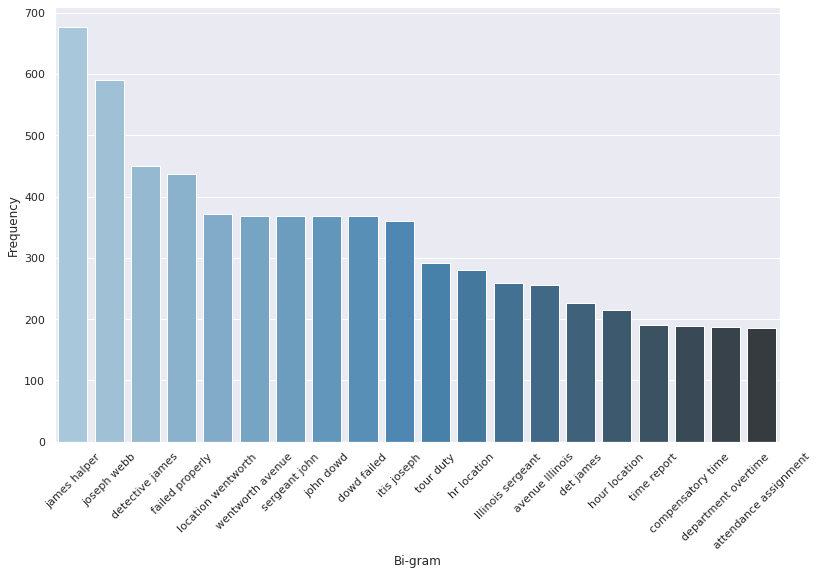

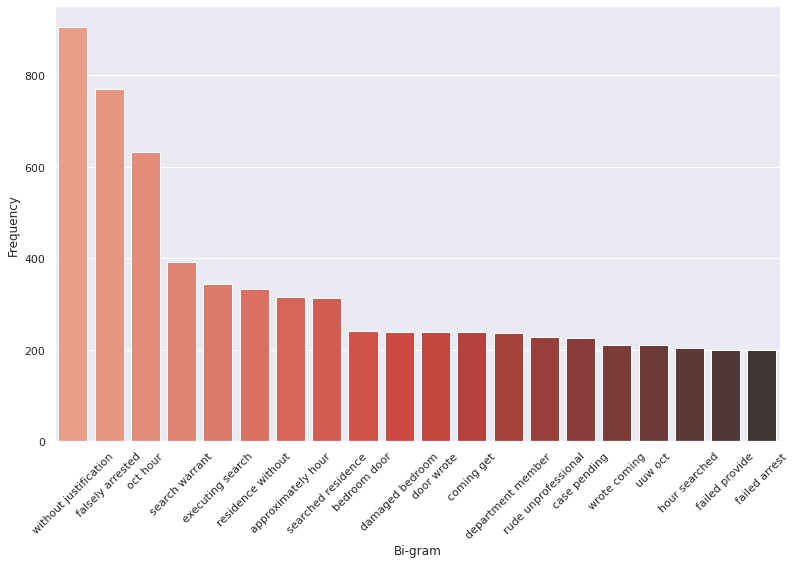

In [ ]:
# Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
fig = plt.figure(1)
g_sus = sns.barplot(x="Bi-gram", y="Frequency", data=top2_df_sus, palette="Blues_d")
g_sus.set_xticklabels(g_sus.get_xticklabels(), rotation=45)
fig = plt.figure(2)
g_unsus = sns.barplot(x="Bi-gram", y="Frequency", data=top2_df_unsus, palette="Reds_d")
g_unsus.set_xticklabels(g_unsus.get_xticklabels(), rotation=45)

# Extract keywords based on TF-IDf scores in the corpus

In [ ]:
# Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re
cv_sus = CountVectorizer(max_df=0.8, stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X_sus = cv_sus.fit_transform(sus_corpus)
cv_unsus = CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X_unsus = cv_unsus.fit_transform(unsus_corpus)



In [ ]:
# Get TF-IDF (term frequency/inverse document frequency) -- 
# TF-IDF lists word frequency scores that highlight words that 
# are more important to the context rather than those that 
# appear frequently across documents

from sklearn.feature_extraction.text import TfidfTransformer 
tfidf_transformer= TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X_sus)
tfidf_transformer.fit(X_unsus)

# Get feature names
sus_feature_names=cv_sus.get_feature_names()
unsus_feature_names=cv_unsus.get_feature_names()

# Fetch document for which keywords needs to be extracted
sus_doc=sus_corpus[sus_ds_count-1]
unsus_doc=unsus_corpus[unsus_ds_count-1]

# Generate tf-idf for the given document
sus_tf_idf_vector=tfidf_transformer.transform(cv_sus.transform([sus_doc]))
unsus_tf_idf_vector=tfidf_transformer.transform(cv_unsus.transform([unsus_doc]))





/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Sort tf_idf in descending order
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=25):
    
    # Use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # Word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        # Keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    # Create tuples of feature,score
    # Results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

# Sort the tf-idf vectors by descending order of scores
sus_sorted_items=sort_coo(sus_tf_idf_vector.tocoo())
unsus_sorted_items=sort_coo(unsus_tf_idf_vector.tocoo())

# Extract only the top n; n here is 25
sus_keywords=extract_topn_from_vector(sus_feature_names,sus_sorted_items,25)
unsus_keywords=extract_topn_from_vector(unsus_feature_names,unsus_sorted_items,25)

# Print the results
print("\nAbstract:")
print(sus_doc)
print("\nKeywords:")
for k in sus_keywords:
    print(k, sus_keywords[k])
    
print("\nAbstract:")
print(unsus_doc)
print("\nKeywords:")
for k in unsus_keywords:
    print(k, unsus_keywords[k])


# import csv
# with open(file_prefix + 'td_idf.csv', 'w', newline="") as csv_file:  
#     writer = csv.writer(csv_file)
#     writer.writerow(["Keyword", "Importance"])
#     for key, value in keywords.items():
#        writer.writerow([key, value])


Abstract:
usc department property bag property receipt usc department property bag property recei complainar personal property receipt july hour arrived cook county department correction processing u c department property inventory bag personal property ecords cash property bag nut wnen bag opened cook county sheriff bolden presence determined property bag contained u c shortage u c sustained

Keywords:
property 0.567
bag 0.323
department 0.272
property bag 0.252
department property 0.204
usc department property 0.136
receipt 0.136
property receipt 0.136
personal property 0.136
department property bag 0.136
cook county 0.136
bag property 0.136
personal 0.13
county 0.13
usc department 0.126
property bag property 0.126
usc 0.099
cook 0.097
sheriff bolden 0.072
sheriff 0.072
sustained 0.068
property inventory 0.068
determined 0.068
county sheriff 0.068
cook county department 0.068

Abstract:
lived seven year used social security number income tax claimed dependent lived seven year used s

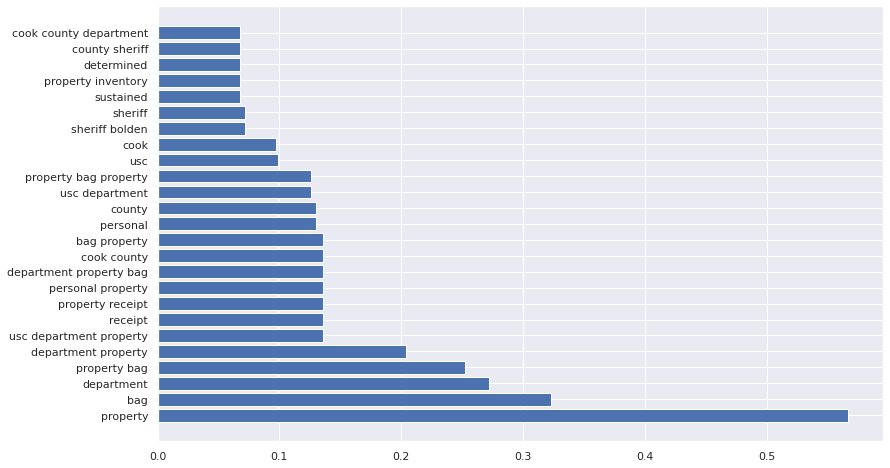

In [ ]:
# Plot sustained TF-IDF
names_sus = list(sus_keywords.keys())
values_sus = list(sus_keywords.values())


plt.barh(range(len(sus_keywords)), values_sus, tick_label=names_sus)
plt.show()

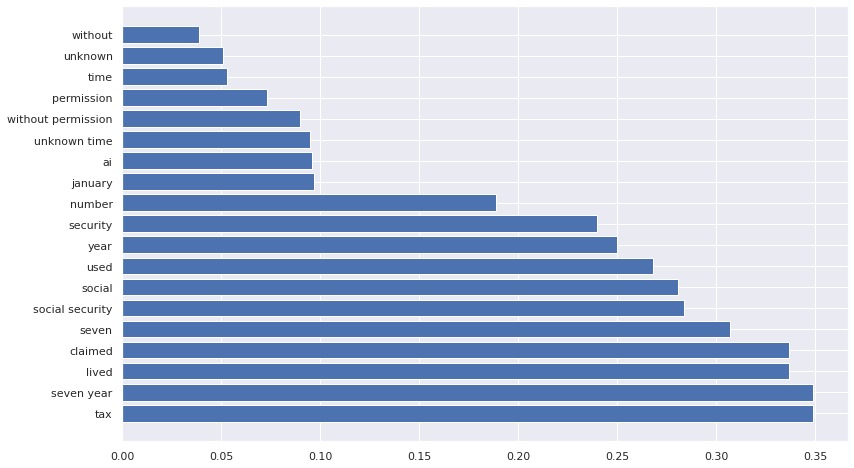

In [ ]:
# Plot unsustained TF-IDF
names_unsus = list(unsus_keywords.keys())
values_unsus = list(unsus_keywords.values())

plt.barh(range(len(unsus_keywords)), values_unsus, tick_label=names_unsus)
plt.show()